Use this notebook to quickly checkout the wave plot and mel spectogram of downloaded samples.  
Add your cells after the **Explore samples below:** cell. The cells before the **Explore samples below:** cell only need to be run when opening the notebook.  
!!!Changes to this notebook will not be tracked.!!!

## Instructions
display sample metadat with the display_sample_metadata function by passing the sample id.  
Load a sample with the `load_audio_sample` function by passing the sample id as a parameter.  
Pass the returned sample into the show_amplitude_wave_plot function to view the waveplot or the show_mel_spectogram function to view the mel spectogram of the sample

## Example:
```Python
#display metadata
display_sample_metadata(123456789)
#get sample as time series
sample, _ = load_audio_sample(123456789)
'''
New cell >
'''
show_amplitude_wave_plot(sample)
'''
New cell > 
'''
show_mel_spectogram(sample)
```

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import math
import IPython.display as ipd
import os
import json
import time
import hdbscan

main_sample_rate = 44100 # 44.1 kHz

samples_metadata = None # dict for species sample info
species_info_df = None # dict with species info

working_dir = os.path.abspath('')

raw_sample_dir = os.path.join(working_dir, 'dataset', 'raw') #path pointing to samples
processed_sample_dir = os.path.join(working_dir, 'dataset', 'processed') #path pointing to samples
samples_metadata_file_path = os.path.join(working_dir, 'dataset', 'data_dictionary', 'samples_metadata.json')
species_info_path = os.path.join(working_dir, 'dataset', 'data_dictionary', 'species_info.csv')

ModuleNotFoundError: No module named 'librosa'

In [2]:
def get_sample_metadata():
    '''
    loads the file that holds information on the downloaded samples and the relevant species
    '''
    with open(samples_metadata_file_path) as f:
        samples_metadata = json.load(f)
    return samples_metadata

def get_species_info():
    '''
    loads the file that holds information on all species
    '''
    species_info_df = pd.read_csv(species_info_path).set_index('species_key')
    return species_info_df

def display_sample_metadata(sample_id):
    '''
    displays the meta data + some additional info on the species in the sample. Takes the sample id as a parameter 
    '''
    if samples_metadata is None:
        raise Exception("sample_meta_data has not been loaded yet. Please run load_sample_meta_data() before this function")
    sample_info = samples_metadata.get(str(sample_id), None)
    if sample_info is None:
        raise Exception("sample with id '{}' was not found in sample_metadata".format(sample_id))
    print('-' * 90)
    print(f"Sample bgifID: {sample_info['gbifID']:>10}")
    print(f"url: {sample_info['recording_link']}")
    print(f"rec time (sec): {sample_info['recording_time_sec']}")
    print(f"rec date: {sample_info['date']}")
    print()
    print(f"decimal latitude: {sample_info['decimal_latitude']}")
    print(f"decimal longitude: {sample_info['decimal_longitude']}")
    main_species_key = sample_info['forefront_bird_key']
    print()
    print(f"main species key: {main_species_key}".format())
    print(f"main scientific name: {species_info_df.at[main_species_key, 'scientific_name']}")
    print(f"main common name: {species_info_df.at[main_species_key, 'common_name']}")
    print()
    if sample_info['behavior']:
        print("Noted behavior in this sample:")
        for index, behavior in enumerate(sample_info['behavior']):
            print(f"\t{str(index)+')'} {behavior}")
    else:
        print("Noted behavior in this sample: None")
    if sample_info['background_birds_keys']:
        print("Background bird's species keys and info:")
        print(f"\t{'':3} {'key':^10} | {'scientific name':30} | {'common_name':30}")
        print(f"\t{'-'*15:^15}┼{'-'*32:32}┼{'-'*30:30}")
        for index, key in enumerate(sample_info['background_birds_keys']):
            print(f"\t{str(index)+')':3} {key:10} | {species_info_df.at[key, 'scientific_name']:30} | {species_info_df.at[key, 'common_name']:30}")
    else:
        print("Background bird's species keys: None")
    print('-' * 90)

def load_audio_sample(sample_id):
    '''
    loads an audio sample by it's id (file name). Returns the audio and the the sample rate
    '''
    audio_file_path = os.path.join(raw_sample_dir, str(sample_id) + '.mp3')
    if not os.path.isfile(audio_file_path): #check if file exists
        raise Exception(f"Sample with id '{sample_id}' does not exist! Available files can be found in the {raw_sample_dir} directory")
    #sample audio at 44.1 khz and get the time series as a numpy array
    time_series, sample_rate = librosa.load(audio_file_path, sr = main_sample_rate)
    #trim empty start and end padding from time series
    time_series, _ = librosa.effects.trim(time_series)

    return time_series, sample_rate

def show_amplitude_wave_plot(time_series, sample_rate):
    '''
    plots the amplitude vs time of the sample 
    '''
    fig, ax = plt.subplots(figsize=(10,5), dpi= 80)


    ax.plot(time_series)

    locator_num = 16 if len(time_series) // sample_rate >= 16 else len(time_series) // sample_rate
    ax.set_xlim(left = 0, right = len(time_series))
    ax.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    formatter = ticker.FuncFormatter(lambda ms, x: time.strftime('%-S', time.gmtime(ms // sample_rate)))
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
    plt.show()
    #librosa.display.waveplot(sample_time_series, sr=main_sample_rate)
def show_mel_spectogram(sample_time_series):
    '''
    plots the melspectogram of the sample
    '''
    S = librosa.feature.melspectrogram(y=sample_time_series, sr=main_sample_rate, n_mels=128, fmax=10000, center = False)
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=main_sample_rate,
                            fmax=10000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [3]:
samples_metadata = get_sample_metadata()
species_info_df = get_species_info()

# Audio Event Detection & Segmentation 

## Audio Events Class

In [4]:
class event: #siimple class for storing the indices of an audio event
    def __init__(self, start_index): #initialize with start index
        self.start_index = start_index
        self.end_index = -1

    def __str__(self):
        return f"start index: {self.start_index} end index: {self.end_index}"

    def __repr__(self):
        return f"start index: {self.start_index} end index: {self.end_index}"

In [5]:
from decimal import Decimal, ROUND_HALF_UP
def round_nearest(value):
    return 

In [6]:
#concatenate events that are close together, the threshold for concatenation is event_distance_max
def concatenate_events(event_arr, event_distance_max):
    new_event_arr = [event_arr[0]]
    for i in range(1, len(event_arr)):
        if (event_arr[i].start_index - new_event_arr[-1].end_index) < event_distance_max:
            new_event_arr[-1].end_index = event_arr[i].end_index
        else:
            new_event_arr.append(event_arr[i])
    return new_event_arr

In [7]:
#remove events that do not meet the event length minimum
def filter_events(event_arr, event_length_min, start_buffer_len = 0, end_buffer_len = 0):
    return [event for event in event_arr if event.end_index - event.start_index - start_buffer_len - end_buffer_len >= event_length_min]

In [8]:
#def store events as audio files
def events_to_audio(event_arr, times_series, sample_rate, sample_id, destination_path, start_buffer_len = 0, end_buffer_len = 0):
    sample_dir_path = os.path.join(destination_path, str(sample_id))
    #check if data_dictionary directory exists
    if os.path.exists(sample_dir_path):
        for filename in os.listdir(sample_dir_path):
            file_path = os.path.join(sample_dir_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete {}. Exceptions: {}'.format(file_path, e)) 
    else:
        os.mkdir(sample_dir_path)

    for index, event in enumerate(event_arr):
        event_start = event.start_index - start_buffer_len if event.start_index - start_buffer_len > 0 else 0 
        event_end = event.end_index + end_buffer_len if event.end_index + end_buffer_len < len(times_series) else len(times_series)
        event_time_series = times_series[event_start : event_end]
        event_file_path = os.path.join(sample_dir_path, f"{index}.wav")
        librosa.output.write_wav(event_file_path, event_time_series, sample_rate)

In [9]:
def plot_time_series_with_audio_events(time_series, audio_events_array, sample_rate):
    #Plots the time series with audio events
    fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
    last_event_end_index = 0
    plot_indices = np.arange(0, len(time_series))
    #plot each audio event in red and the time series inbetween in blue
    for event in audio_events_array:
        ax.plot(plot_indices[last_event_end_index:event.start_index], time_series[last_event_end_index:event.start_index], color='b')
        ax.plot(plot_indices[event.start_index:event.end_index], time_series[event.start_index:event.end_index], color='r')
        last_event_end_index = event.end_index
    ax.plot(plot_indices[last_event_end_index:len(time_series)], time_series[last_event_end_index:len(time_series)],color='b')
    locator_num = 16 if len(time_series) // sample_rate >= 16 else len(time_series) // sample_rate
    ax.set_xlim(left = 0, right = len(time_series))
    ax.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    formatter = ticker.FuncFormatter(lambda ms, x: time.strftime('%-S', time.gmtime(ms // sample_rate)))
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
    plt.show()

## Z Score peak detection

In [10]:
# Own version created from Jean Paul https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data?page=1&tab=votes#tab-top
# and R Kiselev for python verison
def z_score_peak_detection(time_series : np.array, lag : int, threshold : float, influence : float):
    #initialize singal peaks array
    signal_peaks = np.zeros((time_series.shape))  # array denoting if there is a psoitive or negative peak
    #initialize mean and std lag window values as well as time series lag window
    filtered_time_series_window = np.array(time_series[:lag])
    lag_window_mean = np.mean(time_series[:lag])
    lag_window_std = np.std(time_series[:lag])
    for i in range(lag, len(time_series)):
        #shift window to the left
        filtered_time_series_window = np.roll(filtered_time_series_window, -1)
        #if the series value minus the current mean is larger then the threshold times the current std
        if abs(time_series[i] - lag_window_mean) > threshold * lag_window_std:
            if time_series[i] > lag_window_mean: #check for positive or negative peak
                signal_peaks[i] = 1
            else:
                signal_peaks[i] = -1
            filtered_time_series_window[-1] = influence * time_series[i] + (1 - influence) * filtered_time_series_window[-2]
        else: #if no peak was detected
            filtered_time_series_window[-1] = time_series[i]

        lag_window_mean = np.mean(filtered_time_series_window)
        lag_window_std = np.std(filtered_time_series_window)

    return signal_peaks

In [11]:
def auxiliary_z_peak_detection(time_series : np.array, mean_lag : int, std_lag : int, mean_influence : float, std_influence : float, threshold : float):
    signal_peaks = np.zeros((time_series.shape))
    max_lag_length = mean_lag if mean_lag > std_lag else std_lag #fing the larger lag
    #get the windows for mean and std 
    mean_filtered_time_series_window = np.array(time_series[max_lag_length - mean_lag : max_lag_length])
    std_filtered_time_series_window = np.array(time_series[max_lag_length - std_lag : max_lag_length])

    lag_window_mean = np.mean(mean_filtered_time_series_window)
    lag_window_std = np.std(std_filtered_time_series_window)

    for i in range(max_lag_length, len(time_series)):
        mean_filtered_time_series_window = np.roll(mean_filtered_time_series_window, -1)
        std_filtered_time_series_window = np.roll(std_filtered_time_series_window, -1)

        if abs(time_series[i] - lag_window_mean) > threshold * lag_window_std:
            if time_series[i] > lag_window_mean: #check for positive or negative peak
                signal_peaks[i] = 1
            else:
                signal_peaks[i] = -1
            mean_filtered_time_series_window[-1] = mean_influence * time_series[i] + (1 - mean_influence) * mean_filtered_time_series_window[-2]            
            std_filtered_time_series_window[-1] = std_influence * time_series[i] + (1 - std_influence) * std_filtered_time_series_window[-2]            
        else:
            mean_filtered_time_series_window[-1] = time_series[i]            
            std_filtered_time_series_window[-1] = time_series[i]

        lag_window_mean = np.mean(mean_filtered_time_series_window)            
        std_window_mean = np.std(std_filtered_time_series_window)

    return signal_peaks            

In [12]:
def z_score_peak_detection_2D(frequency_time_series : np.array, lag : int, threshold : float, influence : float):
    return np.asarray([z_score_peak_detection(freq_series, lag, threshold, influence) for freq_series in frequency_time_series])

In [13]:
def auxiliary_z_score_peak_detection_2D(frequency_time_series : np.array, mean_lag : int, std_lag : int, mean_influence : float, std_influence : float, threshold : float):
    return np.asarray([auxiliary_z_peak_detection(freq_series, mean_lag, std_lag, mean_influence, std_influence, threshold) for freq_series in frequency_time_series])

In [14]:
def detailed_z_score_peak_detection(time_series : np.array, lag : int, threshold : float, influence : float):
    #initialize mean and std lag window values as well as time series lag window
    filtered_time_series_window = np.array(time_series[:lag])
    lag_window_mean = np.mean(time_series[:lag])
    lag_window_std = np.std(time_series[:lag])
    
    #initialize singal peaks array
    signal_peaks = np.zeros((time_series.shape))  # array denoting if there is a psoitive or negative peak
    signal_means = [lag_window_mean]
    signal_stds = [lag_window_std]

    for i in range(lag, len(time_series)):
        #shift window to the left
        filtered_time_series_window = np.roll(filtered_time_series_window, -1)
        #if the series value minus the current mean is larger then the threshold times the current std
        if abs(time_series[i] - lag_window_mean) > threshold * lag_window_std:
            if time_series[i] > lag_window_mean: #check for positive or negative peak
                signal_peaks[i] = 1
            else:
                signal_peaks[i] = -1
            filtered_time_series_window[-1] = influence * time_series[i] + (1 - influence) * filtered_time_series_window[-2]
        else: #if no peak was detected
            filtered_time_series_window[-1] = time_series[i]

        lag_window_mean = np.mean(filtered_time_series_window)
        lag_window_std = np.std(filtered_time_series_window)

        signal_means.append(lag_window_mean)
        signal_stds.append(lag_window_std)

    return signal_peaks, np.asarray(signal_means), np.asarray(signal_stds)

In [15]:
def show_own_detailed_z_score_plots_at_frequency(frames, freq_bins, target_frequency, sample_rate, step_size, lag : int, threshold : float, influence : float):
    #get nearest fequency bin index
    freq_bin_index = np.argmin(np.abs(freq_bins - target_frequency))
    if freq_bins[freq_bin_index] != target_frequency: print(f"Showing data for closest frequency {freq_bins[freq_bin_index]}")

    y = frames[freq_bin_index]

    signals, means, stds = detailed_z_score_peak_detection(y, lag=lag, threshold=threshold, influence=influence)
    means = np.pad(means, (len(signals) - len(means), 0), 'constant')
    stds = np.pad(stds, (len(signals) - len(stds), 0), 'constant')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), dpi= 80)

    locator_num = 16 if len(y) * step_size // sample_rate >= 16 else len(y) * step_size // sample_rate
    formatter = ticker.FuncFormatter(lambda ms, x: time.strftime('%-S', time.gmtime(ms * step_size // sample_rate)))
    # Plot result
    ax1.plot(np.arange(1, len(y)+1), y)
    ax1.plot(np.arange(1, len(y)+1), means, color="cyan", lw=2)
    ax1.plot(np.arange(1, len(y)+1), means + threshold * stds, color="green", lw=2)
    ax1.plot(np.arange(1, len(y)+1), means - threshold * stds, color="green", lw=2)
    ax1.set_xlim(left = 0, right = len(y))
    ax1.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    ax1.xaxis.set_major_formatter(formatter)
    ax1.set_ylabel('DB')

    
    ax2.step(np.arange(1, len(y)+1), signals, color="red", lw=2)
    ax2.set_xlim(left = 0, right = len(y))
    ax2.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylim(-1.0, 1.0)

    plt.show()

    for i in range(len(stds)):
        print(means[i], stds[i])

In [16]:
import numpy as np
import pylab
# R Kiselev python verison
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [17]:
def show_detailed_z_score_plots_at_frequency(frames, freq_bins, target_frequency, sample_rate, step_size, lag : int, threshold : float, influence : float):
    #get nearest fequency bin index
    freq_bin_index = np.argmin(np.abs(freq_bins - target_frequency))
    if freq_bins[freq_bin_index] != target_frequency: print(f"Showing data for closest frequency {freq_bins[freq_bin_index]}")

    y = frames[freq_bin_index]

    result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), dpi= 80)

    locator_num = 16 if len(y) * step_size // sample_rate >= 16 else len(y) * step_size // sample_rate
    formatter = ticker.FuncFormatter(lambda ms, x: time.strftime('%-S', time.gmtime(ms * step_size // sample_rate)))
    # Plot result
    ax1.plot(np.arange(1, len(y)+1), y)
    ax1.plot(np.arange(1, len(y)+1), result["avgFilter"], color="cyan", lw=2)
    ax1.plot(np.arange(1, len(y)+1), result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
    ax1.plot(np.arange(1, len(y)+1), result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
    ax1.set_xlim(left = 0, right = len(y))
    ax1.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    ax1.xaxis.set_major_formatter(formatter)
    ax1.set_ylabel('DB')


    ax2.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
    ax2.set_xlim(left = 0, right = len(y))
    ax2.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylim(-1.0, 1.0)

    plt.show()

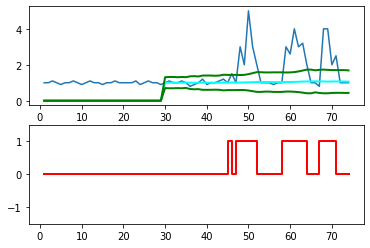

In [18]:
# Own version created from Jean Paul https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data?page=1&tab=votes#tab-top
# and R Kiselev for python verison
y = np.array([1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1])

# Settings: lag = 30, threshold = 5, influence = 0
lag = 30
threshold = 5
influence = 0.03

# Run algo with settings from above
result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)

pylab.ylim(-1.5, 1.5)
pylab.show()

## Fourier Transform

In [19]:
#split a time series into multiple frames given a window size and step size
def get_even_time_series_frames(time_series : np.array, window_size : int, step_size : int):
    #calculate number of frames (has to be an even number?)
    frame_num = (len(time_series) - window_size)/step_size + 1
    series = time_series #copy series
    if frame_num % 2 != 0:  #ensure that number of frames is a even number
        frame_num = math.ceil(frame_num / 2.0) * 2 #round number of frames to even number
        padding_len = (frame_num - 1) * step_size + window_size - len(time_series)  #calculate padding length 
        series = np.pad(series, (0, padding_len), 'constant') #pad end of series with 0s
    frame_num = int(frame_num)
    #create and return frames from rime series 
    return np.array([ series[step*step_size:step*step_size+window_size] for step in range(frame_num)])

In [20]:
def calculate_power_spectrum(time_series_frames, n_fft = None):
    mag_frames = np.abs(np.fft.rfft(time_series_frames, n_fft)) # for each frame compute the n point fourier transform 
    pow_frames = ((1.0 / n_fft) * ((mag_frames) ** 2))
    return pow_frames

In [21]:
def apply_hanning_window(frames : np.array):
    frames *= np.hanning(frames.shape[frames.ndim - 1])

In [22]:
#remove default 2048
def get_frequency_bins(bin_num, sample_rate):
    return np.fft.rfftfreq(bin_num, d =1.0/sample_rate)

In [23]:
def librosa_power_to_db(power_frames):
    return librosa.power_to_db(power_frames, ref=np.max)#10 * np.log10(pow_frames / np.max(pow_frames))

In [24]:
def trim_to_frequency_range(frames, fft_bin_freq, max_freq, min_freq = 0):
    #get closest frequency in bin
    max_index = np.argmin(np.abs(fft_bin_freq - max_freq))
    min_index = np.argmin(np.abs(fft_bin_freq - min_freq))

    return frames[:,min_index:max_index], fft_bin_freq[min_index:max_index]

In [25]:
def get_audio_events_from_summed_spectral_peaks(time_series, start_buffer_len = 0, end_buffer_len = 0):
    event_arr = []          #create array for audio events
    detected_event = False  #set audio event detected to false
    index = 0

    while index < len(time_series): 
        if abs(time_series[index]) >= 1:  #if the absolute amplitude exceeds 1
            if not detected_event:          #if not event has been detected start new event
                #make sure we do not add negative index as start index
                start_index = index - start_buffer_len if index - start_buffer_len > 0 else 0   
                event_arr.append(event(start_index))  #add audio event to array
                detected_event = True       #set audio event detected to true
        elif detected_event:    #if the amplitude falls below the 1 and an audio event is set
            detected_event = False  # set audio event detected to false
            event_arr[-1].end_index = index + end_buffer_len #set current index to end index
            index += end_buffer_len - 1 # increase index to end of buffer -1 because index gets increased by one at end of loop
        index+=1    #increase index

    if detected_event:  #if we parsed the time series but an audio event is set 
        event_arr[-1].end_index = len(time_series) - 1   # set end index of last event to index of last element
    return event_arr

In [26]:
def convert_spectral_events_to_time_series_events(event_arr, step_size):
    for index in range(len(event_arr)):
        event_arr[index].start_index = event_arr[index].start_index * step_size
        event_arr[index].end_index = event_arr[index].end_index * step_size

In [27]:
def draw_spectogram(spectogram_matrix, sample_rate, step_size, title = 'Spectrogram', x_label = None, y_labels = None, y_tick_num = 6):
    f = plt.figure(figsize=(10,5), dpi= 80)
    ax = f.add_subplot()
    ax.set_title(title) #set title 
    mfcc = ax.matshow(spectogram_matrix, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
    ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
    ax.set_xlabel('Time (sec)')
    locator_num = 16 if spectogram_matrix.shape[1] * step_size // sample_rate >= 16 else spectogram_matrix.shape[1] * step_size // sample_rate
    ax.set_xlim(left = 0, right = spectogram_matrix.shape[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(locator_num))
    formatter = ticker.FuncFormatter(lambda ms, x: time.strftime('%-S', time.gmtime(ms * step_size // sample_rate)))
    ax.xaxis.set_major_formatter(formatter)
    
    ax.invert_yaxis() #have y axis start from the bottom
    ax.set_ylabel('Hz')
    y_tick_steps = int(len(y_labels) / y_tick_num)
    ax.set_yticks(np.arange(0, len(y_labels), y_tick_steps))
    ax.set_yticklabels(y_labels[0::y_tick_steps])

    plt.tight_layout()
    plt.colorbar(mfcc, format='%+2.0f dB');
    plt.show()

### Miscellaneous & Unused

In [28]:
from scipy import ndimage as ndi

def local_maximum_detect_peaks(spectogram):
    return ndi.maximum_filter(spectogram, size = (40, 20), mode='constant')

In [29]:
def compute_outliers(sample_frames):
    #print(sample_frames.shape)
    frames_shape = sample_frames.shape
    outlier_frame = np.zeros((frames_shape[0] - 1, frames_shape[1]))

    mean_freq_db = np.mean(sample_frames, axis = 0)
    #print(mean_freq_db)
    for i in range(len(outlier_frame)):
        outlier_frame[i] = sample_frames[i] - mean_freq_db

    outlier_frame = np.clip(outlier_frame, 0, np.max(outlier_frame))
    print(outlier_frame.shape)
    return outlier_frame

In [30]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler

# db = DBSCAN(eps=3, min_samples=6).fit(peak_coordinates)

# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)


# cluster_colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters_))

# colors = [cluster_colors[x] if x >= 0
#                   else [0.5, 0.5, 0.5, 0.0]
#                   for x in db.labels_]
# #print(clusterer.labels_)
# #cluster_member_colors = [cluster_colors[-1]  for x, p in
# #                         zip(cluster_colors, clusterer.probabilities_)]
# f = plt.figure(figsize=(10,5), dpi= 80)
# plt.scatter(peak_coordinates[:,1], peak_coordinates[:,0], s=2, linewidth=0, c=colors)
# len(set(clusterer.labels_))

# Explore samples below:

In [31]:
sample_id = 2243804495

In [32]:
##Spectogram variables
window_size = 2048
step_size = 512

#frequency trims variables
max_frequency = 10000
min_frequency = 1000

In [33]:
## z score peak detection variables
mean_lag_window_size = 128
std_lag_window_size = 128
mean_influence = .001
std_influence = .001
threshold = 2.3

In [34]:
## Event processing

#set max distance to 100 ms 
event_distance_max = int(0.1 * main_sample_rate) # 100 ms * sample rate will give us the max distance in 
#set min event length to 125 ms 
event_length_min = int(0.125 * main_sample_rate) # 125ms * sample rate will give us the max distance in "index" units 

In [35]:
#Events to audio varaibles
#set half a sec as buffer lengths 
start_buffer_len = int(.5 * main_sample_rate)
end_buffer_len = int(.5 * main_sample_rate)

In [36]:
display_sample_metadata(sample_id)

------------------------------------------------------------------------------------------
Sample bgifID: 2243804495
url: https://www.xeno-canto.org/sounds/uploaded/ZNCDXTUOFL/Bonasia_bonasia_Bialowieza_Poland_Jarek_Matusiak_20091205.mp3
rec time (sec): 14
rec date: 2009-12-05

decimal latitude: 52.7001
decimal longitude: 23.8501

main species key: 2473663
main scientific name: tetrastes bonasia
main common name: hazel grouse

Noted behavior in this sample:
	0) call
Background bird's species keys: None
------------------------------------------------------------------------------------------


In [37]:
sample, _ = load_audio_sample(sample_id)

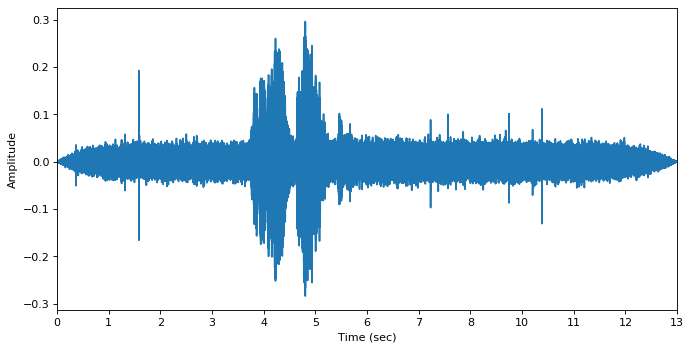

In [38]:
show_amplitude_wave_plot(sample, main_sample_rate)

## Create Spectogram

Create time series frames from time series

In [39]:

time_series_frames = get_even_time_series_frames(sample, window_size, step_size)

Compute the Short Term Fourier Transform and convert the spectogram scale from magnitude to power

In [40]:
#apply hanning window on time series frames
apply_hanning_window(time_series_frames)
#calculate the power spectrum
power_frames = calculate_power_spectrum(time_series_frames, window_size)
#get the frequency bins from for the window size
rfft_bin_freq = get_frequency_bins(window_size, main_sample_rate)

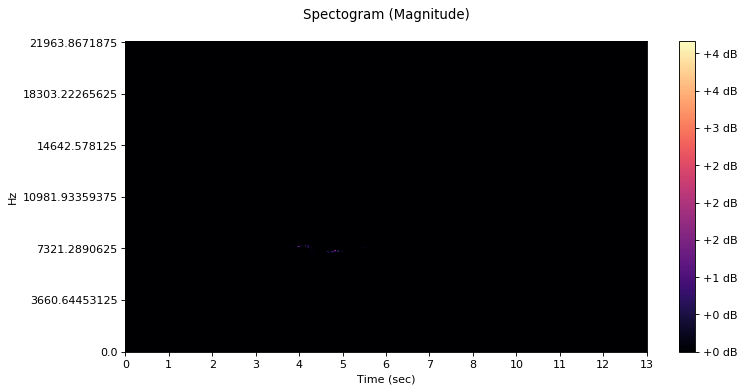

In [41]:
#show power spectogram
draw_spectogram(np.array(power_frames).T, main_sample_rate, step_size, title =  "Spectogram (Magnitude)", y_labels = rfft_bin_freq)

Convert power spectogram to decibel spectogram & and trim frequency bins to specifc range

In [42]:
db_frames = librosa_power_to_db(power_frames)
db_frames, rfft_bin_freq = trim_to_frequency_range(db_frames, rfft_bin_freq, max_frequency, min_frequency)

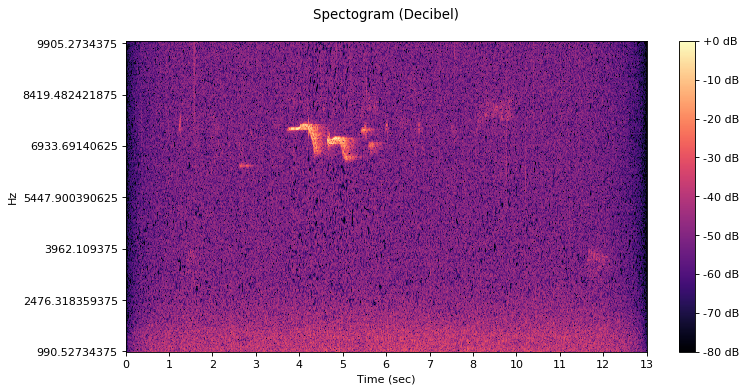

In [43]:
draw_spectogram(np.array(db_frames).T, main_sample_rate, step_size, title = "Spectogram (Decibel)", y_labels = rfft_bin_freq)

detect peaks in spectogram 

In [58]:
#transpose  [frames, frequencies] -> [frequencies, frames]
T_db_frames = np.array(db_frames).T
#get peaks
peaks = auxiliary_z_score_peak_detection_2D(T_db_frames, mean_lag_window_size, std_lag_window_size, mean_influence, std_influence, threshold)
#filter out "negative" peaks 
clipped_peaks = np.clip(peaks, 0, 1)

Showing data for closest frequency 7407.421875


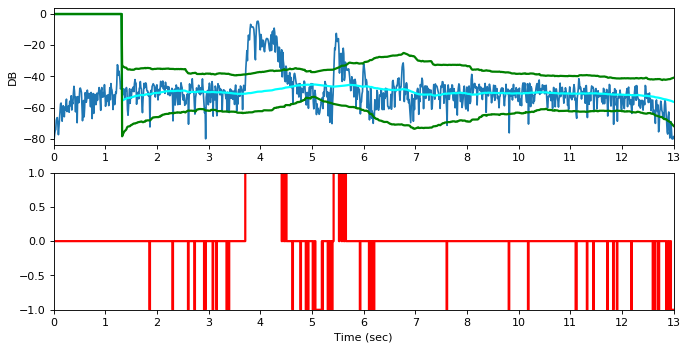

3594495114 7.73693227318223
-48.29526055824611 7.731615691038983
-48.353566310492994 7.7843492309787905
-48.413932191833595 7.839220119839214
-48.484750799663644 7.908593056680979
-48.55185121822316 7.971244779741647
-48.615502525721254 8.027990865052649
-48.67238698079369 8.0749301469684
-48.6560615445578 8.067113145517268
-48.71446493666145 8.12937493192098
-48.75715807448855 8.151313283783713
-48.68314377656331 8.157925362664798
-48.64946397958366 8.174202209977915
-48.668322191269255 8.16454988063007
-48.68200565124943 8.15963022598745
-48.79328954256255 8.211327794955832
-48.77304317974612 8.205399154890456
-48.74583661965207 8.19613152558655
-48.72244005633947 8.196936590669642
-48.69032529318555 8.200058364225868
-48.65417510471262 8.202098643577694
-48.58299571374798 8.224999040881249
-48.517645123583584 8.242320149104582
-48.44682985739915 8.268053263750383
-48.47933646088938 8.269731719278047
-48.499382539041505 8.283030574771974
-48.45324392722109 8.275866932754264
-48.40578

In [59]:
show_own_detailed_z_score_plots_at_frequency(T_db_frames, rfft_bin_freq, 7400, main_sample_rate, step_size, 128, 2.7, 0.001)

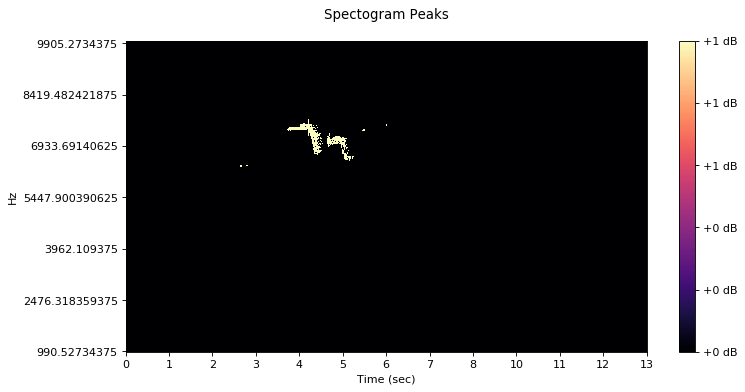

In [60]:
draw_spectogram(clipped_peaks, main_sample_rate, step_size, title = "Spectogram Peaks", y_labels = rfft_bin_freq)

Compute events from detected peaks

from scipy import ndimage
im_blur = ndimage.gaussian_filter(clipped_peaks, 10)
draw_spectogram(im_blur, main_sample_rate, step_size, title = "Spectogram Peaks", y_labels = rfft_bin_freq)

In [61]:
peak_coordinates = np.array(np.where(clipped_peaks == 1)).T

In [62]:
#sum the frames over the window steps
summed_peak_array = np.sum(clipped_peaks, axis=0)

In [63]:
events = get_audio_events_from_summed_spectral_peaks(summed_peak_array)
convert_spectral_events_to_time_series_events(events, step_size)

events = concatenate_events(events, event_distance_max)

events = filter_events(events, event_length_min, 0, 0)

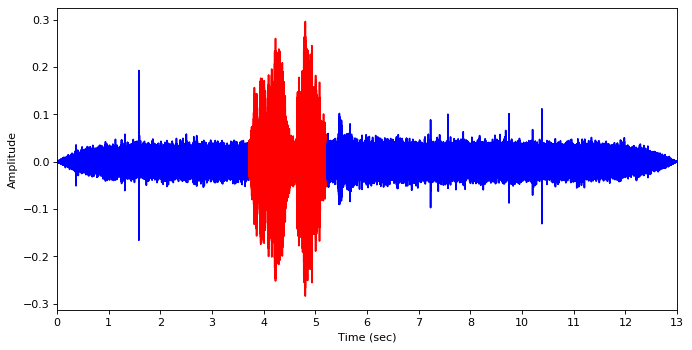

In [64]:
plot_time_series_with_audio_events(sample, events, main_sample_rate)

In [65]:
class cluster_range:
    def __init__(self):
        self.min_x = 1
        self.max_x = -1
        self.min_y = 1
        self.max_y = -1

def get_cluster_range(cluster_coordinates):
    return np.min(cluster_coordinates[:,1]), np.max(cluster_coordinates[:,1]), np.min(cluster_coordinates[:,0]), np.max(cluster_coordinates[:,0])

def get_audio_events_from_hdbscan(peak_coordinates):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(peak_coordinates)
    clusters_coordinates = [[] for i in range(len(set(clusterer.labels_)) - 1)]

    for index, cluster_index in enumerate(clusterer.labels_):
        if cluster_index != -1:
            clusters_coordinates[cluster_index].append(peak_coordinates[index])

    cluster_ranges = np.array([np.asarray(get_cluster_range(np.array(coordinates))) for coordinates in clusters_coordinates])

    return  cluster_ranges

In [66]:
def convert_spectral_clusters_to_time_series_clusters(clusters, step_size):
    for index in range(len(clusters)):
        event_arr[index][0] = event_arr[index][0] * step_size
        event_arr[index][1] = event_arr[index][1] * step_size

In [67]:
cluster_ranges = get_audio_events_from_hdbscan(peak_coordinates)

In [68]:
def convert_spectral_clusters_to_time_series_clusters(clusters, step_size):
    for index in range(len(clusters)):
        event_arr[index][0] = event_arr[index][0] * step_size
        event_arr[index][1] = event_arr[index][1] * step_size

number of clusters: 2


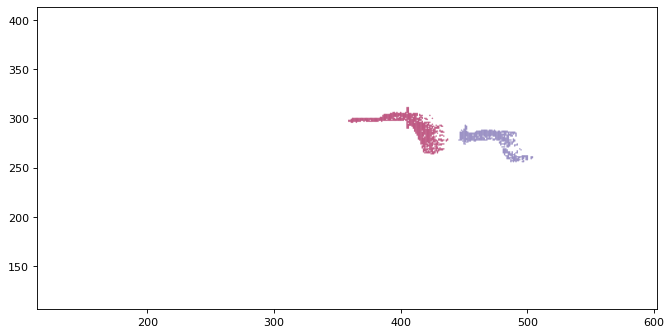

In [69]:
def adjust_alpha(color, alpha):
    color[-1] = alpha
    return color

import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=25).fit(peak_coordinates)
#color_palette = sns.color_palette('deep', 8)
cluster_colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusterer.labels_))-1))

colors = [cluster_colors[x] if x >= 0
                  else [0.5, 0.5, 0.5, 0.0]
                  for x in clusterer.labels_]

colors_with_probs = [ adjust_alpha(x, p) for x, p in
                         zip(colors, clusterer.probabilities_)]

f = plt.figure(figsize=(10,5), dpi = 80)
plt.scatter(peak_coordinates[:,1], peak_coordinates[:,0], s=2, linewidth=0, c=colors_with_probs)
print(f"number of clusters: {(len(set(clusterer.labels_)) - 1)}")

number of clusters: 2


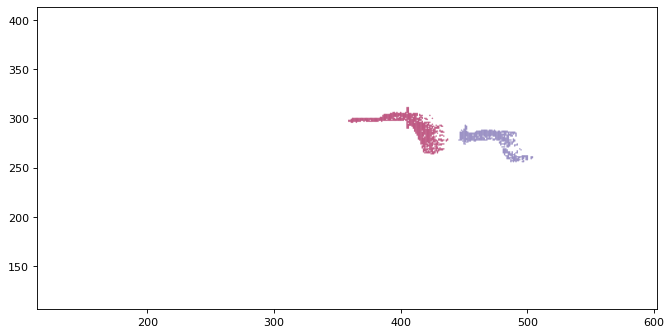

In [70]:
clusters_coordinates = [[] for i in range(len(set(clusterer.labels_)) - 1)]

for index, cluster_index in enumerate(clusterer.labels_):
    if cluster_index != -1:
        clusters_coordinates[cluster_index].append(peak_coordinates[index])

cluster_ranges = np.array([np.asarray(get_cluster_range(np.array(coordinates))) for coordinates in clusters_coordinates])

for index in range(len(cluster_ranges)):
        cluster_ranges[index][0] = cluster_ranges[index][0] * step_size
        cluster_ranges[index][1] = cluster_ranges[index][1] * step_size

exclude_clusters_arr = []
for index, c_range in enumerate(cluster_ranges):
    if not (c_range[1] - c_range[0] >= event_length_min):
        exclude_clusters_arr.append(index)

cluster_labels = clusterer.labels_

for index in exclude_clusters_arr:
    cluster_labels[cluster_labels == index] = -1

colors = [cluster_colors[x] if x >= 0
                  else [0.5, 0.5, 0.5, 0.0]
                  for x in cluster_labels]

f = plt.figure(figsize=(10,5), dpi = 80)
plt.scatter(peak_coordinates[:,1], peak_coordinates[:,0], s=2, linewidth=0, c=colors)
print(f"number of clusters: {(len(set(cluster_labels)) - 1)}")  
#


#clusterer.labels_
#event for event in event_arr if event.end_index - event.start_index - start_buffer_len - end_buffer_len >= event_length_min

In [71]:
events_to_audio(events, sample, main_sample_rate, sample_id, processed_sample_dir, start_buffer_len, end_buffer_len)